In [ ]:
!pip install pandas numpy scikit-learn tensorflow matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from tqdm import tqdm


from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


read the final csv

In [ ]:
OUT_DIR = '/content/drive/MyDrive/'
df= pd.read_csv(os.path.join(OUT_DIR,"scada_full_raw.csv"))


## per-window feature engineering


since the paper used frame-level features. we can get better detection with sliding windows ( 1s windows) and aggregated statistics per (src,dst) pair.

We will compute for windows of W=1.0 second and also packet-count windows of N=100 packets (both). Features per window:

- count, mean_len, std_len, min_len, max_len

- unique_src_count, unique_dst_count

- protocol distribution (one-hot / entropy)

- avg_interarrival, std_interarrival

- info-text features: tf-idf top-k per window (optional heavy)

In [ ]:
label_map = {
    "day1_02_10_20": "Normal",
    "day3_03_16_20": "Attack",
    "day4_03_17_20": "Attack",
    "day5_03_18_20": "Attack",
    "day6_03_19_20": "Attack"
}

df = df.sort_values(['source_file','frame.number']).reset_index(drop=True)
df['time_rel'] = pd.to_numeric(df['time_rel'], errors='coerce').fillna(0.0)

# Sliding window parameters
WINDOW_SEC = 1.0

agg_rows = []
for src_file, sub in df.groupby('source_file'):
    times = sub['time_rel'].values
    start = times.min()
    end = times.max()
    bins = np.arange(start, end + WINDOW_SEC, WINDOW_SEC)
    sub['win_idx'] = np.searchsorted(bins, sub['time_rel']) - 1
    for win, g in sub.groupby('win_idx'):
        if g.empty: continue
        d = {
            'source_file': src_file,
            'win_idx': win,
            't_start': g['time_rel'].min(),
            't_end': g['time_rel'].max(),
            'pkt_count': len(g),
            'mean_len': g['frame.len'].mean(),
            'std_len': g['frame.len'].std(),
            'min_len': g['frame.len'].min(),
            'max_len': g['frame.len'].max(),
            'unique_srcs': g['ip.src'].nunique(),
            'unique_dsts': g['ip.dst'].nunique(),
            'protocol_entropy': -(g['protocol_final'].value_counts(normalize=True).apply(lambda p: p*np.log2(p)).sum() if len(g)>0 else 0),
            'avg_interarrival': np.mean(np.diff(sorted(g['time_rel']))) if len(g)>1 else 0,
        }
        agg_rows.append(d)
win_df = pd.DataFrame(agg_rows)
win_df['day_label'] = win_df['source_file'].map(label_map)
win_df.to_csv(os.path.join(OUT_DIR,"scada_windowed_1s.csv"), index=False)
print("Windowed dataset saved:", win_df.shape)


Windowed dataset saved: (87141, 14)


# EDA

protocol level insights

/tmp/ipython-input-3605092174.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=prot_counts.index, x=prot_counts.values, palette='viridis')


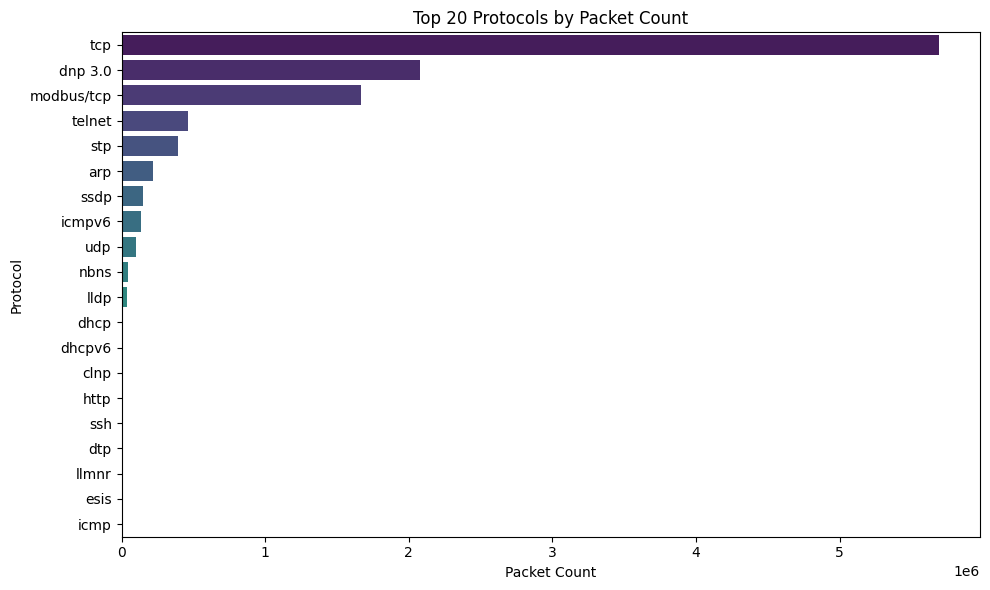

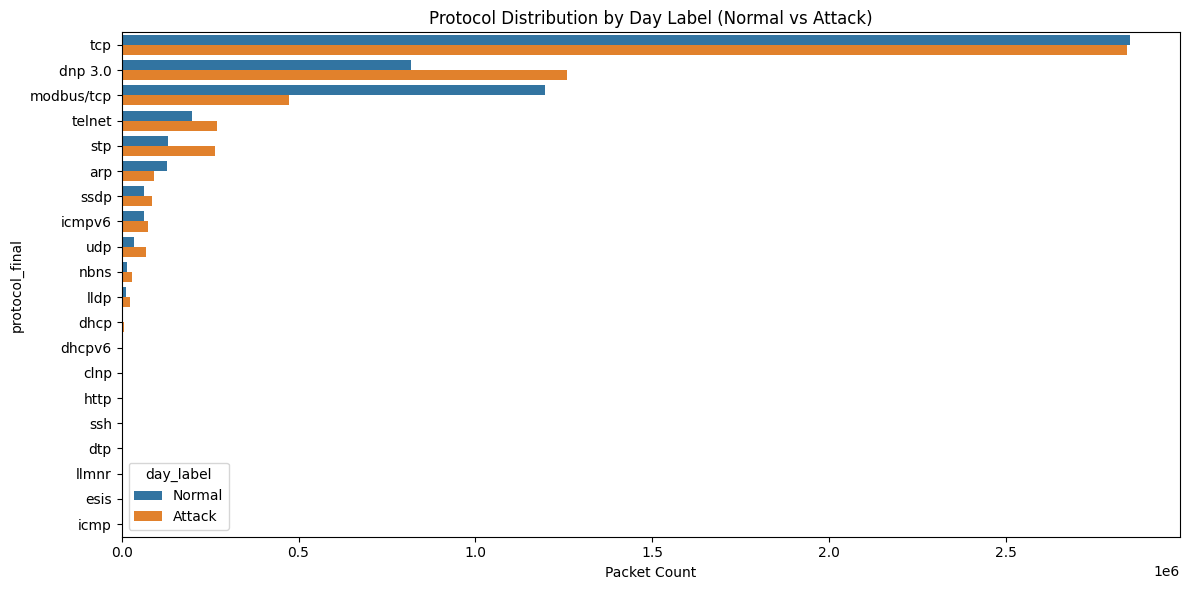

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Top 20 protocols
prot_counts = df['protocol_final'].value_counts().nlargest(20)

plt.figure(figsize=(10,6))
sns.barplot(y=prot_counts.index, x=prot_counts.values, palette='viridis')
plt.title("Top 20 Protocols by Packet Count")
plt.xlabel("Packet Count")
plt.ylabel("Protocol")
plt.tight_layout()
plt.show()

# Percentage contribution
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='protocol_final', hue='day_label', order=prot_counts.index)
plt.title("Protocol Distribution by Day Label (Normal vs Attack)")
plt.xlabel("Packet Count")
plt.tight_layout()
plt.show()


source and destination IP patterns

/tmp/ipython-input-4286957583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_src.index, x=top_src.values, palette='magma')


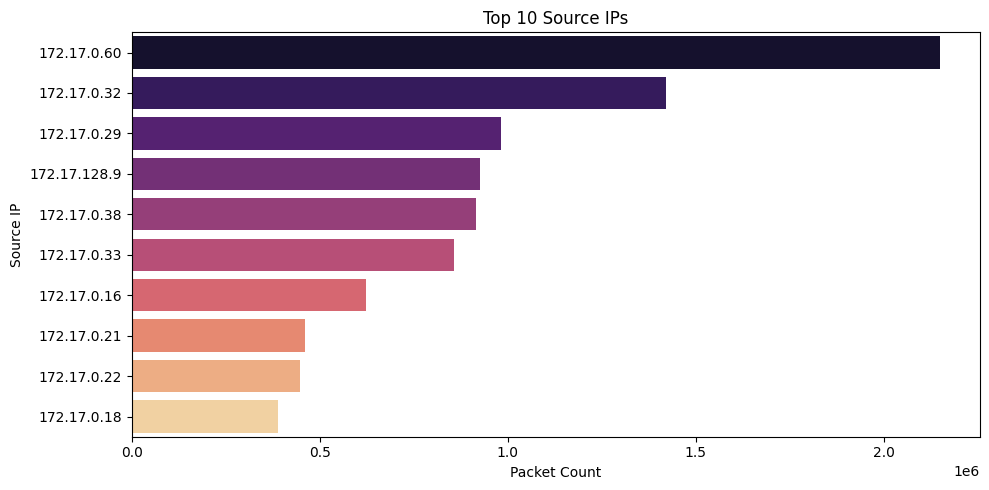

/tmp/ipython-input-4286957583.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_dst.index, x=top_dst.values, palette='coolwarm')


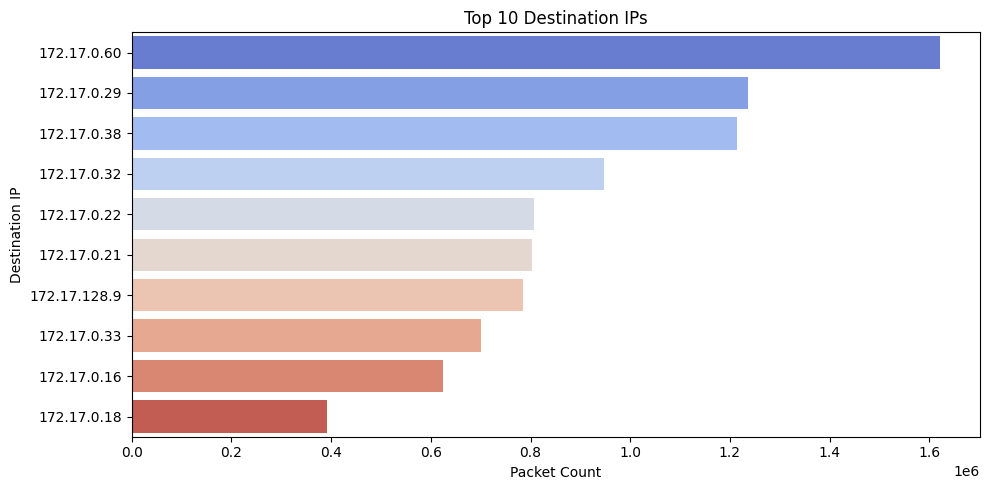

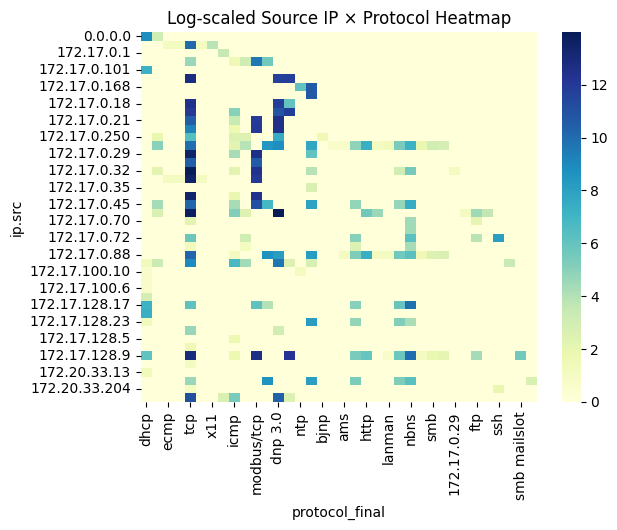

In [ ]:
# Top 10 source IPs
top_src = df['ip.src'].value_counts().nlargest(10)
plt.figure(figsize=(10,5))
sns.barplot(y=top_src.index, x=top_src.values, palette='magma')
plt.title("Top 10 Source IPs")
plt.xlabel("Packet Count")
plt.ylabel("Source IP")
plt.tight_layout()
plt.show()

# Top destination IPs
top_dst = df['ip.dst'].value_counts().nlargest(10)
plt.figure(figsize=(10,5))
sns.barplot(y=top_dst.index, x=top_dst.values, palette='coolwarm')
plt.title("Top 10 Destination IPs")
plt.xlabel("Packet Count")
plt.ylabel("Destination IP")
plt.tight_layout()
plt.show()


#protocol-specific IP behavior.

ip_proto = df.groupby(['ip.src','protocol_final']).size().unstack(fill_value=0)
sns.heatmap(np.log1p(ip_proto), cmap='YlGnBu')
plt.title("Log-scaled Source IP × Protocol Heatmap")
plt.show()


packet length analysis

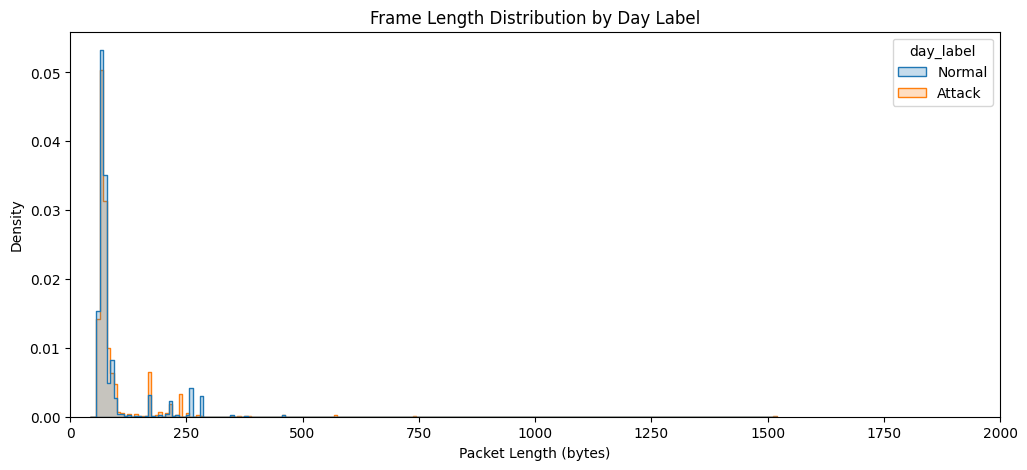

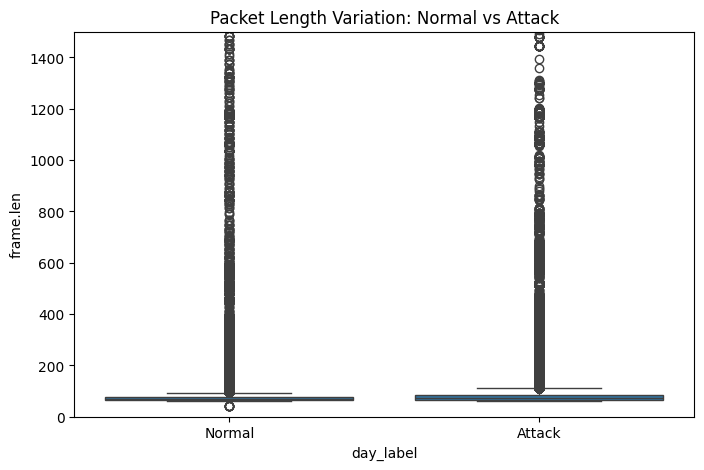

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(data=df, x='frame.len', hue='day_label',
             bins=200, stat='density', element='step', common_norm=False)
plt.xlim(0, 2000)  # adjust for SCADA typical packets
plt.title("Frame Length Distribution by Day Label")
plt.xlabel("Packet Length (bytes)")
plt.ylabel("Density")
plt.show()

# Boxplot for per-day comparison
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='day_label', y='frame.len')
plt.ylim(0, 1500)
plt.title("Packet Length Variation: Normal vs Attack")
plt.show()


Temproal behaviour to see Bursts or spikes in packet counts

<Figure size 1400x500 with 0 Axes>

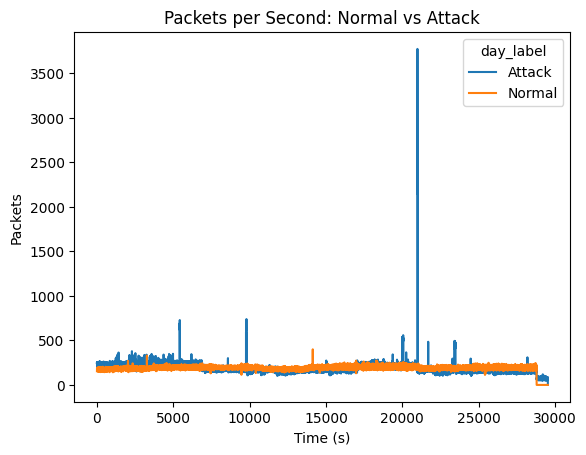

In [ ]:
# Packets per second
full['sec'] = full['time_rel'].astype(int)
pkt_per_sec = full.groupby(['sec','day_label']).size().unstack(fill_value=0)

plt.figure(figsize=(14,5))
pkt_per_sec.plot()
plt.title("Packets per Second: Normal vs Attack")
plt.xlabel("Time (s)")
plt.ylabel("Packets")
plt.show()


Entropy / Diversity metrics

High entropy would mean many protocols in short windows → unusual traffic mixing.

Low entropy means repetitive traffic → automated SCADA commands, potential scan/flood.

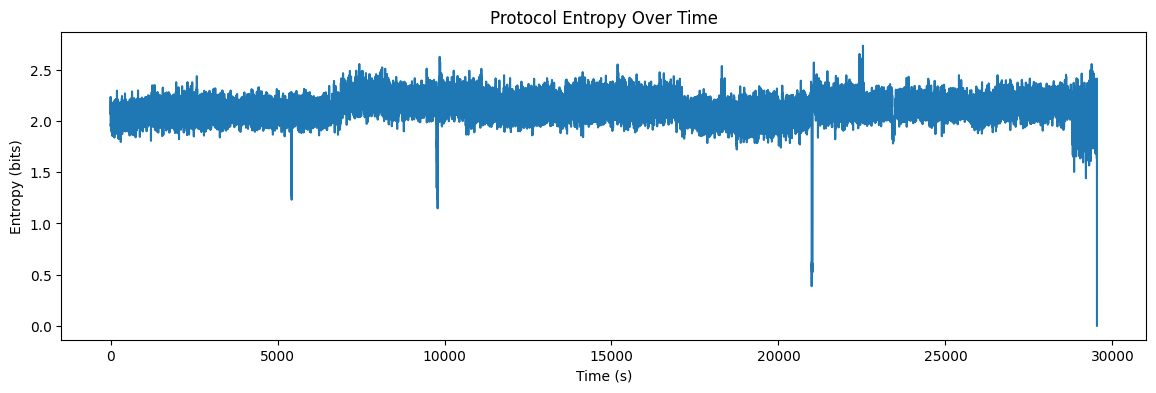

In [ ]:
from scipy.stats import entropy

# Protocol entropy per second
proto_entropy = full.groupby('sec')['protocol_final'].apply(lambda x: entropy(x.value_counts(), base=2))
plt.figure(figsize=(14,4))
proto_entropy.plot()
plt.title("Protocol Entropy Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Entropy (bits)")
plt.show()


## k-means clustering on normal data

this will help us see baseline patterns of normal behavior for comparison with Attack windows.

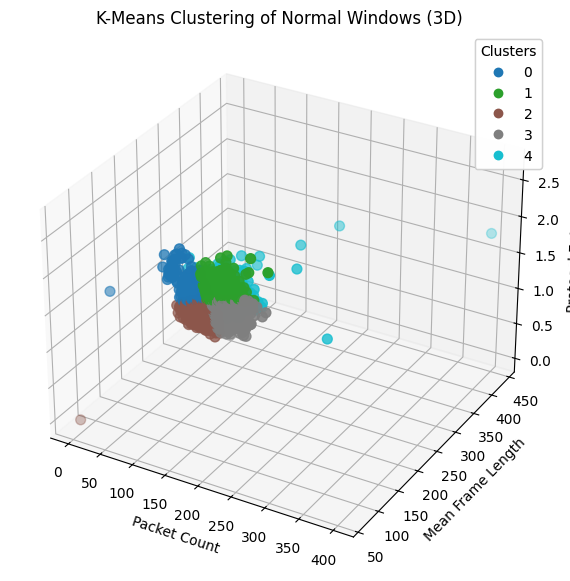

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Select three features for 3D clustering
features_3d = ['pkt_count', 'mean_len', 'protocol_entropy']

# Use Normal windows only for clustering
normal_win = win_df[win_df['day_label']=='Normal'].copy()
X_3d = normal_win[features_3d].fillna(0)

# Standardize features
scaler = StandardScaler()
X_3d_s = scaler.fit_transform(X_3d)

# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
normal_win['cluster'] = kmeans.fit_predict(X_3d_s)

# 3D visualization
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Scatter points colored by cluster
scatter = ax.scatter(
    normal_win['pkt_count'],
    normal_win['mean_len'],
    normal_win['protocol_entropy'],
    c=normal_win['cluster'], cmap='tab10', s=50
)

ax.set_xlabel('Packet Count')
ax.set_ylabel('Mean Frame Length')
ax.set_zlabel('Protocol Entropy')
ax.set_title('K-Means Clustering of Normal Windows (3D)')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


Timeline Visualization of Anomalies

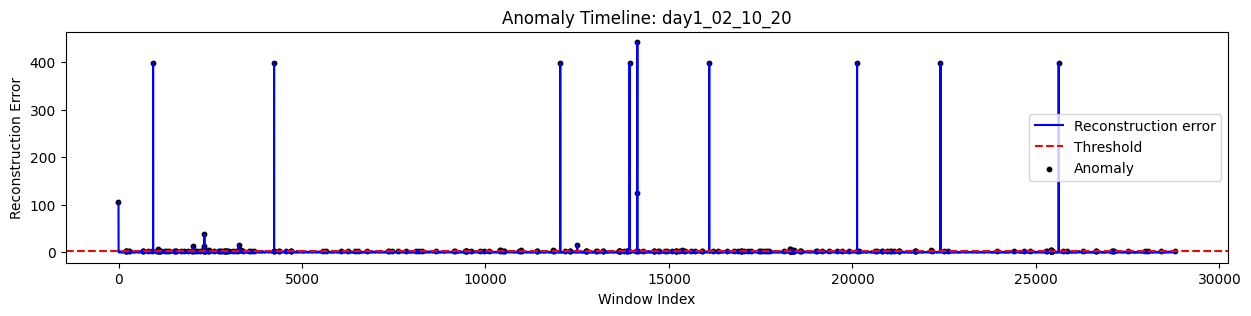

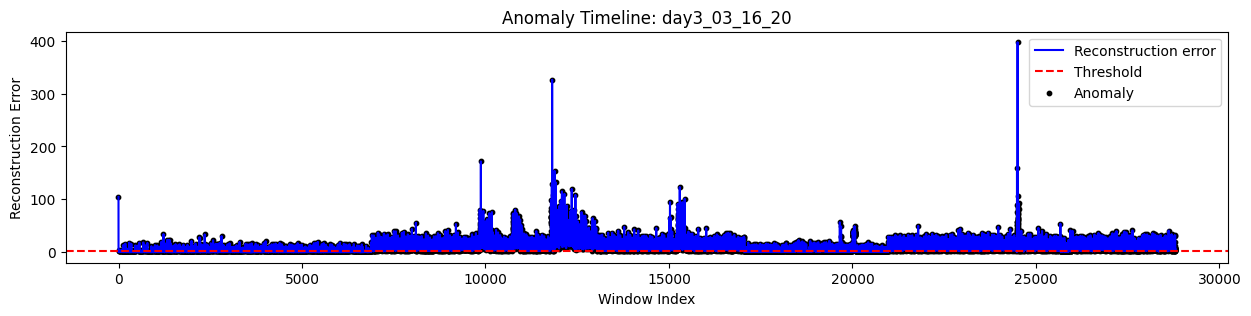

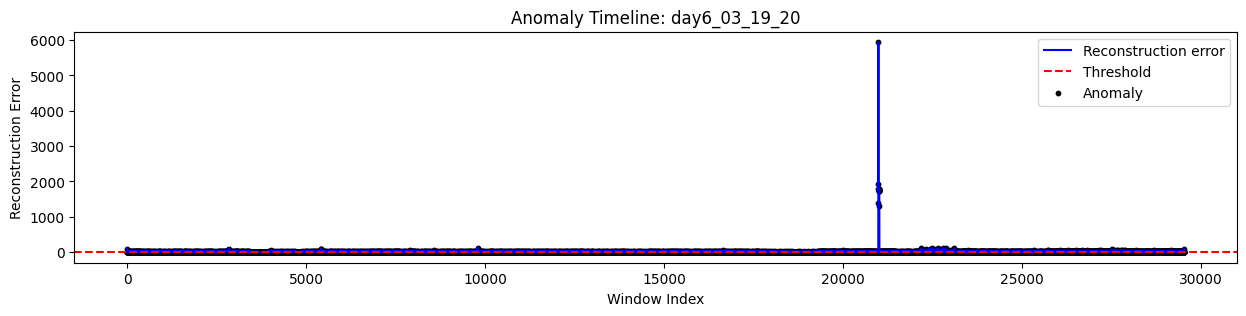

In [ ]:
import matplotlib.pyplot as plt

for src_file, sub in win_df.groupby('source_file'):
    plt.figure(figsize=(15,3))
    plt.plot(sub['win_idx'], sub['recon_error'], color='blue', label='Reconstruction error')
    plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
    anomalies = sub[sub['anomaly']==1]
    plt.scatter(anomalies['win_idx'], anomalies['recon_error'], color='black', label='Anomaly', s=10)
    plt.title(f"Anomaly Timeline: {src_file}")
    plt.xlabel("Window Index")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.show()


## Loading windowed data for model training

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load windowed dataset
win_df = pd.read_csv("/content/scada_analysis/scada_windowed_1s.csv")

# Features for AE
features_ae = ['pkt_count','mean_len','std_len','min_len','max_len',
               'unique_srcs','unique_dsts','protocol_entropy','avg_interarrival']

# Split Normal vs Attack
normal_win = win_df[win_df['day_label']=='Normal']
attack_win = win_df[win_df['day_label']=='Attack']

X_train = normal_win[features_ae].fillna(0)
X_test = attack_win[features_ae].fillna(0)

# Scale features
scaler_ae = StandardScaler()
X_train_s = scaler_ae.fit_transform(X_train)
X_test_s = scaler_ae.transform(X_test)

print("Training shape:", X_train_s.shape)
print("Testing shape:", X_test_s.shape)


Training shape: (28800, 9)
Testing shape: (58341, 9)


In [ ]:
from tensorflow.keras import layers, models

input_dim = X_train_s.shape[1]
enc_dim = max(4, input_dim//2)

# Encoder-Decoder AE
inp = layers.Input(shape=(input_dim,))
x = layers.Dense(enc_dim*2, activation='relu')(inp)
x = layers.Dense(enc_dim, activation='relu')(x)
latent = layers.Dense(enc_dim//2, activation='relu')(x)
x = layers.Dense(enc_dim, activation='relu')(latent)
x = layers.Dense(enc_dim*2, activation='relu')(x)
out = layers.Dense(input_dim, activation=None)(x)

ae = models.Model(inputs=inp, outputs=out)
ae.compile(optimizer='adam', loss='mse')
ae.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259 (1.01 KB)

 Trainable params: 259 (1.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = ae.fit(
    X_train_s, X_train_s,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=2
)


Epoch 1/50
203/203 - 5s - 24ms/step - loss: 0.9622 - val_loss: 0.5883
Epoch 2/50
203/203 - 1s - 4ms/step - loss: 0.8160 - val_loss: 0.5255
Epoch 3/50
203/203 - 1s - 4ms/step - loss: 0.7723 - val_loss: 0.4985
Epoch 4/50
203/203 - 1s - 3ms/step - loss: 0.7476 - val_loss: 0.4871
Epoch 5/50
203/203 - 1s - 4ms/step - loss: 0.7292 - val_loss: 0.4799
Epoch 6/50
203/203 - 1s - 4ms/step - loss: 0.7132 - val_loss: 0.4703
Epoch 7/50
203/203 - 1s - 3ms/step - loss: 0.6916 - val_loss: 0.4457
Epoch 8/50
203/203 - 1s - 3ms/step - loss: 0.6574 - val_loss: 0.4107
Epoch 9/50
203/203 - 1s - 3ms/step - loss: 0.6161 - val_loss: 0.3839
Epoch 10/50
203/203 - 1s - 3ms/step - loss: 0.5803 - val_loss: 0.3528
Epoch 11/50
203/203 - 1s - 4ms/step - loss: 0.5533 - val_loss: 0.3362
Epoch 12/50
203/203 - 1s - 4ms/step - loss: 0.5352 - val_loss: 0.3226
Epoch 13/50
203/203 - 1s - 3ms/step - loss: 0.5208 - val_loss: 0.3184
Epoch 14/50
203/203 - 1s - 3ms/step - loss: 0.5111 - val_loss: 0.3054
Epoch 15/50
203/203 - 1s - 3

caluclate the threshold at which it detects anomalies

In [ ]:
# Reconstruction
recon_train = np.mean((ae.predict(X_train_s) - X_train_s)**2, axis=1)
recon_test = np.mean((ae.predict(X_test_s) - X_test_s)**2, axis=1)

# Threshold (e.g., 99th percentile of Normal)
threshold = np.percentile(recon_train, 99)
print("Threshold for anomaly:", threshold)


900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Threshold for anomaly: 1.5257762899689427


this will give us:

Normal windows above threshold → false positives
Attack windows above threshold → true positives

In [ ]:
# Add reconstruction error & anomaly labels
win_df['recon_error'] = np.nan
win_df.loc[win_df['day_label']=='Normal', 'recon_error'] = recon_train
win_df.loc[win_df['day_label']=='Attack', 'recon_error'] = recon_test

win_df['anomaly'] = (win_df['recon_error'] > threshold).astype(int)

# Quick stats
win_df.groupby(['day_label','anomaly']).size()


day_label  anomaly
Attack     0           1985
           1          56356
Normal     0          28512
           1            288
dtype: int64

creating a confusion matrix

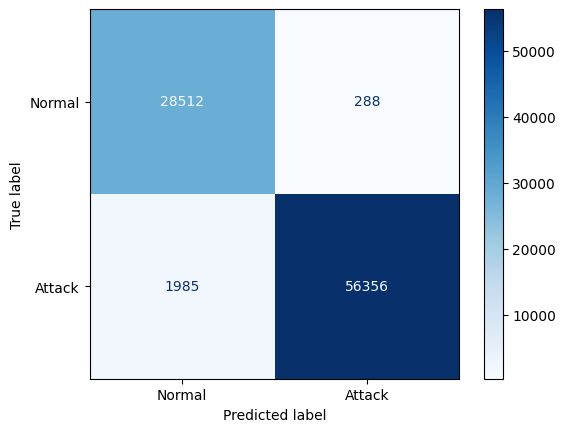

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = (win_df['day_label'] == 'Attack').astype(int)  # 0=Normal, 1=Attack
y_pred = win_df['anomaly']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Normal','Attack'])
disp.plot(cmap='Blues')


evaluate perofmance metrics

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_true = np.concatenate([np.zeros(len(recon_train)), np.ones(len(recon_test))])
y_pred = np.concatenate([(recon_train>threshold).astype(int), (recon_test>threshold).astype(int)])

print(classification_report(y_true, y_pred, target_names=['Normal','Attack']))
print("ROC AUC:", roc_auc_score(y_true, np.concatenate([recon_train, recon_test])))


              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96     28800
      Attack       0.99      0.97      0.98     58341

    accuracy                           0.97     87141
   macro avg       0.96      0.98      0.97     87141
weighted avg       0.98      0.97      0.97     87141

ROC AUC: 0.9968800255299781


#